### Autoregressive RNN on Alanine Dipeptide

In [47]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.distributions as dist
import torch.optim as optim

from torch.utils.data import DataLoader
import sys
import os

In [48]:
## load required modules
## load MMCDataset class
## MMCD_path = "/path/to/MMCD"
MMCD_path = "./"
sys.path.append(MMCD_path)
from mmcd import MMCDataset

name = 'dialanine'
data_path = os.path.join(MMCD_path, "data")

dataset_train = MMCDataset(root = data_path,
                           molecule_name = name,
                           train = True,
                           coordinate_type = 'internal',
                           lazy_load = False)
train_loader = DataLoader(dataset_train,
                          num_workers = 4,
                          batch_size = 256, #256 is the default batch size
                          shuffle = True)
dataset_test = MMCDataset(root = data_path,
                          molecule_name = name,
                          train = False,
                          coordinate_type = 'internal',
                          lazy_load = False)
test_loader = DataLoader(dataset_test,
                         num_workers = 4,
                         batch_size = 256) #256 is the default batch size

In [49]:
def flatten_data(data):
    """
    Input: data is a single dictionary item. In this case, for dialanine, it is a dictionary item 
    with six keys, each referencing a torch.tensor of size [256, 256, 256, (256, 19),(256, 19), (256, 19)]
    respectively. The batch size is 256, so the batch data is size [256, 256, 256, (256, 19), (256, 19), 
    (256, 19)]. Each dialiene molecule is  size [1, 1, 1, 19, 19, 19].
    
    Output: the dictionary item flattened into a 1-D tensor. It is a 1-D tensor of size 60
    for dialanine. We want a length 256 data object where each item is a 60-length 1-d tensor
    The resulting data object has shape: torch.Size of [256, 60].
    """
    result = torch.cat(
        [data['reference_particle_2_bond'][:, None],
         data['reference_particle_3_bond'][:, None],
         data['reference_particle_3_angle'][:, None],
         data['bond'], data['angle'], data['dihedral']],
        dim = -1)

    return result

def rebuild(flat, data_length = 19):
    """
    Input: flattened tensor of torch.Size [256, 60], rebuild and return
    the original molecule, a dictionary item. The inverse of the flatten_data function.
    """
    data_length = 19 #this is particular to dialene
    result = {}

    result['reference_particle_1_xyz'] = torch.zeros((flat.shape[0], 3))
    result['reference_particle_2_bond'] = flat[:, 0]
    result['reference_particle_3_bond'] = flat[:, 1]
    result['reference_particle_3_angle'] = flat[:, 2]

    start = 3
    end = start + data_length
    result['bond'] = flat[:, start:end]

    start = end
    end = start + data_length
    result['angle'] = flat[:, start:end]

    start = end
    end = start + data_length
    result['dihedral'] = flat[:, start:end]

    return result

In [50]:
class InternalCoordinateJordanRNNv1(nn.Module):
    def __init__(self, batch_size = 256):
        super(InternalCoordinateJordanRNNv1, self).__init__()
        
        self.batch_size = 256
        self.hidden_size = 10
        self.x_size = 1 #Generating each entry in the Z-matrix at a time. 

        #Used to generate y_1, which is not conditioned on any input. 
        self.h_0 = torch.zeros(256, 10) #Torch.zeros(self.batch_size, self.hidden_size)
        
        #Modules for everything that is not the first input.
        self.y_mu_linears = nn.ModuleList([nn.Linear(10, 1) for index in range(60)]) #Means
        self.y_sig_linears = nn.ModuleList([nn.Linear(10, 1) for index in range(60)]) #Concentrations
        self.h_linears = nn.ModuleList([nn.Linear(3, 10) for index in range(60)])
        
        #Indexing Rules
        #x = [batchsize, values]. Size = [256, 60]
        #y = [batchsize, values, iteration]. Size = [256, 2, 60]
        #h = [batchsize, values, iteration]. Size = [256, 10, 60]
    
    def mu_activation(self, y_mu_1):
        return 2*np.pi*torch.tanh(y_mu_1)

    def sig_activation(self, y_sig_1):
        return 100*torch.sigmoid(torch.relu(y_sig_1)) + 0.1

    def forward(self, X): 
        #Notice here that h_0 and y_0 are explicitly calculated. 
        h = torch.zeros(X.size()[0], self.hidden_size, 1) #[256, 10, 1]

        y_mu_1 = self.mu_activation(
            self.y_mu_linears[0](h[:, :, 0])
            )

        y_sig_1 = self.sig_activation(
            self.y_sig_linears[0](h[:, :, 0])
            )

        y_cat = torch.cat([y_mu_1, y_sig_1], dim=1)
        y_cat = torch.unsqueeze(y_cat, dim = 2)
        y = y_cat 

        for index in range(1, 60, 1): #Recall generating the 0th item, so start at first item.
            x_t = X[:, index-1:index] 
            y_t_minus_1 = y[:, :, index-1]  
            x_and_y = torch.cat([x_t, y_t_minus_1], dim=1) #size = [256, 3]

            new_h = torch.relu( self.h_linears[index-1](x_and_y) ) #size = [256, 10]
            
            y_mu_1 = self.mu_activation(
                self.y_mu_linears[index](new_h)
            )

            y_sig_1 = self.sig_activation(
                self.y_sig_linears[index](new_h)
            )

            y_cat = torch.cat([y_mu_1, y_sig_1], dim=1)
            y_cat = torch.unsqueeze(y_cat, dim = 2)

            new_h = torch.unsqueeze(new_h, dim = 2)
            h = torch.cat([h, new_h], dim = 2)
            y = torch.cat([y, y_cat], dim = 2)
        return h, y

    def loss(self, X, Y, tensor_form = False):
        #The loss function is the negative log likelihood itself. 
        q_theta = dist.VonMises(torch.squeeze(Y[:, 0, :]), torch.squeeze(Y[:, 1, :]))

        if tensor_form == True:
            return q_theta.log_prob(X)

        return - torch.sum(q_theta.log_prob(X))
    
    def sample(self, num_samples = 256):
        h = torch.zeros(num_samples, self.hidden_size, 1) #[256, 10, 1]

        y_mu_1 = self.mu_activation(
            self.y_mu_linears[0](h[:, :, 0])
            )

        y_sig_1 = self.sig_activation(
            self.y_sig_linears[0](h[:, :, 0])
            )

        y_cat = torch.cat([y_mu_1, y_sig_1], dim=1)
        dist_temp = dist.VonMises(y_cat[:, 0], y_cat[:, 1])

        y_cat = torch.unsqueeze(y_cat, dim = 2)
        y = y_cat 
        
        x = dist_temp.sample()
        x = x.unsqueeze(dim = 1)
       
        #Generate the second up to last sample.
        for index in range(1, 60, 1): 

            x_t = x[:, index-1:index] #size = [256, 1]
            y_t_minus_1 = y[:, :, index-1] #size = [256, 2]

            x_and_y = torch.cat( [x_t, y_t_minus_1], dim = 1 ) #size = [256, 3]
            new_h = torch.relu( self.h_linears[index](x_and_y) ) #size = [256, 10]
            
            y_mu_1 = self.mu_activation(
                self.y_mu_linears[index](new_h)
            )

            y_sig_1 = self.sig_activation(
                self.y_sig_linears[index](new_h)
            )

            y_cat = torch.cat([y_mu_1, y_sig_1], dim=1)
                
            new_dist_temp = dist.VonMises(y_cat[:, 0], y_cat[:, 1])
            new_x = new_dist_temp.sample()

            h = torch.cat([h, new_h.unsqueeze(dim=2)], dim = 2)

            y = torch.cat([y, y_cat.unsqueeze(dim=2)], dim = 2)

            x = torch.cat([x, new_x.unsqueeze(dim=1)], dim = 1)
        return x

In [51]:
class InternalCoordinateJordanRNNv2(nn.Module):
    def __init__(self, batch_size = 256):
        super(InternalCoordinateJordanRNNv2, self).__init__()
        
        self.batch_size = 256
        self.hidden_size = 10
        
        #Modules for everything that is not the first input.
        self.y_mu_linears = nn.ModuleList([nn.Linear(10, 1) for index in range(60)]) #Means
        self.y_sig_linears = nn.ModuleList([nn.Linear(10, 1) for index in range(60)]) #Concentrations
        self.h_linears = nn.ModuleList([nn.Linear(3, 10) for index in range(60)])
        
        #Indexing Rules
        #x = [batchsize, values]. Size = [256, 60]
        #y = [batchsize, values, iteration]. Size = [256, 2, 60]
        #h = [batchsize, values, iteration]. Size = [256, 10, 60]
        
        self.size = 3
        
    def mu_activation(self, y_mu_1):
        return 2*np.pi*torch.tanh(y_mu_1)

    def sig_activation(self, y_sig_1):
        return torch.exp(7*torch.tanh(y_sig_1))

    def forward(self, X): 
        #Notice here that h_0 and y_0 are explicitly calculated. 
        h = torch.zeros(X.size()[0], self.hidden_size, 1).to(device) #[256, 10, 1]

        y_mu_1 = self.mu_activation(
            self.y_mu_linears[0](h[:, :, 0])
            )

        y_sig_1 = self.sig_activation(
            self.y_sig_linears[0](h[:, :, 0])
            )

        y_cat = torch.cat([y_mu_1, y_sig_1], dim=1)
        y_cat = torch.unsqueeze(y_cat, dim = 2)
        y = y_cat  

        for index in range(1, self.size, 1): #Recall generating the 0th item, so start at first item.
            x_t = X[:, index-1:index] #x_0 
            y_t_minus_1 = y[:, :, index-1]  #y_0
            x_and_y = torch.cat([x_t, y_t_minus_1], dim=1) #size = [256, 3]

            new_h = torch.relu( self.h_linears[index-1](x_and_y) ) #size = [256, 10]
            
            y_mu_1 = self.mu_activation(
                self.y_mu_linears[index](new_h)
            )

            y_sig_1 = self.sig_activation(
                self.y_sig_linears[index](new_h)
            )

            y_cat = torch.cat([y_mu_1, y_sig_1], dim=1)
            y_cat = torch.unsqueeze(y_cat, dim = 2)

            new_h = torch.unsqueeze(new_h, dim = 2)
            h = torch.cat([h, new_h], dim = 2)
            y = torch.cat([y, y_cat], dim = 2)
        
        return h, y
    
    def sample(self, num_samples = 256):
        h = torch.zeros(num_samples, self.hidden_size, 1).to(device) #[256, 10, 1]

        y_mu_1 = self.mu_activation(
            self.y_mu_linears[0](h[:, :, 0])
            )

        y_sig_1 = self.sig_activation(
            self.y_sig_linears[0](h[:, :, 0])
            )

        y_cat = torch.cat([y_mu_1, y_sig_1], dim=1)
        dist_temp = dist.Normal(y_cat[:, 0], y_cat[:, 1])

        y_cat = torch.unsqueeze(y_cat, dim = 2)
        y = y_cat 
        
        x = dist_temp.sample()
        x = x.unsqueeze(dim = 1)

        #Generate the second up to last sample.
        for index in range(1, self.size, 1): 
            x_t = x[:, index-1:index] #x_0 #size = [256, 1]
            y_t_minus_1 = y[:, :, index-1] #x_0 #size = [256, 2]

            x_and_y = torch.cat( [x_t, y_t_minus_1], dim = 1 ) #size = [256, 3]
            new_h = torch.relu( self.h_linears[index-1](x_and_y) ) #size = [256, 10]
            
            y_mu_1 = self.mu_activation(
                self.y_mu_linears[index](new_h)
            )

            y_sig_1 = self.sig_activation(
                self.y_sig_linears[index](new_h)
            )

            y_cat = torch.cat([y_mu_1, y_sig_1], dim=1)
            
            if index < 41:
                new_dist_temp = dist.Normal(y_cat[:, 0], y_cat[:, 1])
            
            if index > 41:
                new_dist_temp = dist.VonMises(y_cat[:, 0], y_cat[:, 1])

            new_x = new_dist_temp.sample()

            h = torch.cat([h, new_h.unsqueeze(dim=2)], dim = 2)
            
            y = torch.cat([y, y_cat.unsqueeze(dim=2)], dim = 2)

            x = torch.cat([x, new_x.unsqueeze(dim=1)], dim = 1)
        
        #means = y[:, 0, :]
        #stds = y[:, 1, :]
        return x#, means, stds

    def loss(self, X, Y, tensor_form = False):
        #The loss function is the negative log likelihood itself. 
        
        q_theta = dist.Normal(loc = Y[:, 0, :41], scale = Y[:, 1, :41])
        q_theta_dihedrals = dist.VonMises(loc = Y[:, 0, 41:], concentration = Y[:, 1, 41:])

        if tensor_form == True:
            return q_theta.log_prob(X[:, :self.size]), q_theta_dihedrals.log_prob(X[:, 41:])

        return - torch.sum(q_theta.log_prob(X[:, 0:self.size])) #- torch.sum(q_theta_dihedrals.log_prob(X[:, 41:]))

### Training Loop

In [53]:
device = torch.device("cuda")
model = InternalCoordinateJordanRNNv2().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-3)  #lr is step size, arbitrarily picked.

def train(epoch):
    model.train()
    train_loss = 0

    for batch_idx, (data, _) in enumerate(train_loader):
        #Flatten the data into a tensor of size (256, 60) tensor before putting it into the GPU
        data = flatten_data(data)
        data = data.to(device)
        optimizer.zero_grad()

        h, y = model(data)
        loss = model.loss(X = data, Y = y)
        loss.backward()

        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:#args.log_interval == 0: #by default, args.log_interval = 10
            print('Train Epoch:', epoch, '[{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(

                #len(train_loader) should be 625
                batch_idx, #index of the batch we are on 
                len(train_loader), #how many batches are in the data loader
                100. * batch_idx / len(train_loader), #progress percentage
                loss.item() / len(train_loader))  #hardcoded batch size
                )

for epoch in range(1, 11):
    train(epoch)

    '''
    sample =  model.sample(1000)
    sample = rebuild(sample)
    potential_energy_q_theta = dataset_train.compute_potential_energy_for_ic(sample)
    print(np.sum(potential_energy_q_theta)/1000)
    '''

Train Epoch: 1 [0/625 (0%)]	Loss: 4.810403
Train Epoch: 1 [100/625 (16%)]	Loss: -1.610314


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb4be3cf5e0>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fb4be3cf5e0>  File "/home/jared/anaconda3/envs/MMCD/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Exception ignored in: 
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb4be3cf5e0>Traceback (most recent call last):
  File "/home/jared/anaconda3/envs/MMCD/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
self._shutdown_workers()

Traceback (most recent call last):
      File "/home/jared/anaconda3/envs/MMCD/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Exception ignored in:     
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fb4be3cf5e0>self._shutdown_workers()Traceback (most recent call last):
self._shutdown_workers()

  File "/home/jared/anaconda3/envs/MMCD/lib/

Train Epoch: 1 [200/625 (32%)]	Loss: -2.396343
Train Epoch: 1 [300/625 (48%)]	Loss: -2.773876
Train Epoch: 1 [400/625 (64%)]	Loss: -2.755608
Train Epoch: 1 [500/625 (80%)]	Loss: -3.070287
Train Epoch: 1 [600/625 (96%)]	Loss: -3.049930
Train Epoch: 2 [0/625 (0%)]	Loss: -3.191386
Train Epoch: 2 [100/625 (16%)]	Loss: -3.249724


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb4be3cf5e0>
Traceback (most recent call last):
  File "/home/jared/anaconda3/envs/MMCD/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb4be3cf5e0>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fb4be3cf5e0>Traceback (most recent call last):
  File "/home/jared/anaconda3/envs/MMCD/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/jared/anaconda3/envs/MMCD/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    Exception ignored in: self._shutdown_workers()

Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fb4be3cf5e0>  File "/home/jared/anaconda3/envs/MMCD/lib/python3.8/site-packages/torch/utils/data/dataloader.py"

Train Epoch: 2 [200/625 (32%)]	Loss: -3.499537
Train Epoch: 2 [300/625 (48%)]	Loss: -3.565166
Train Epoch: 2 [400/625 (64%)]	Loss: -3.671080
Train Epoch: 2 [500/625 (80%)]	Loss: -3.749914
Train Epoch: 2 [600/625 (96%)]	Loss: -3.869512
Train Epoch: 3 [0/625 (0%)]	Loss: -3.760728
Train Epoch: 3 [100/625 (16%)]	Loss: -3.971102


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb4be3cf5e0>
Traceback (most recent call last):
  File "/home/jared/anaconda3/envs/MMCD/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/jared/anaconda3/envs/MMCD/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    Exception ignored in: Exception ignored in: if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x7fb4be3cf5e0>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fb4be3cf5e0>  File "/home/jared/anaconda3/envs/MMCD/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x7fb4be3cf5e0>    Traceback (most recent call last):
assert self._parent_pid == os.getpid(), 'can only test a child process'Traceback (most recent call last):

  File "/home/jared/anaconda3/envs/MMCD/lib/pytho

Train Epoch: 3 [200/625 (32%)]	Loss: -3.980013
Train Epoch: 3 [300/625 (48%)]	Loss: -4.026354
Train Epoch: 3 [400/625 (64%)]	Loss: -4.087415
Train Epoch: 3 [500/625 (80%)]	Loss: -4.057673
Train Epoch: 3 [600/625 (96%)]	Loss: -4.123960
Train Epoch: 4 [0/625 (0%)]	Loss: -4.059513
Train Epoch: 4 [100/625 (16%)]	Loss: -4.106102


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb4be3cf5e0>
Traceback (most recent call last):
  File "/home/jared/anaconda3/envs/MMCD/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb4be3cf5e0>
Traceback (most recent call last):
  File "/home/jared/anaconda3/envs/MMCD/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/jared/anaconda3/envs/MMCD/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
        Exception ignored in: Exception ignored in: self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7fb4be3cf5e0>
Traceback (most recent call last):
  File "/home/jared/anaconda3/envs/MMCD/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
if w.is_alive():    
<function _MultiPro

Train Epoch: 4 [200/625 (32%)]	Loss: -4.169712
Train Epoch: 4 [300/625 (48%)]	Loss: -4.137571
Train Epoch: 4 [400/625 (64%)]	Loss: -4.122628
Train Epoch: 4 [500/625 (80%)]	Loss: -4.057091
Train Epoch: 4 [600/625 (96%)]	Loss: -4.188373
Train Epoch: 5 [0/625 (0%)]	Loss: -4.124563
Train Epoch: 5 [100/625 (16%)]	Loss: -3.983315


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb4be3cf5e0>
Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb4be3cf5e0>
Traceback (most recent call last):
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fb4be3cf5e0>  File "/home/jared/anaconda3/envs/MMCD/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/home/jared/anaconda3/envs/MMCD/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Exception ignored in:     
self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7fb4be3cf5e0>Traceback (most recent call last):


    Traceback (most recent call last):
  File "/home/jared/anaconda3/envs/MMCD/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/home/jared/anaconda3/envs/MMCD/lib/python3.8/site-packages/torch/utils/data/dataloader.py

Train Epoch: 5 [200/625 (32%)]	Loss: -4.090931
Train Epoch: 5 [300/625 (48%)]	Loss: -4.033424
Train Epoch: 5 [400/625 (64%)]	Loss: -4.163846
Train Epoch: 5 [500/625 (80%)]	Loss: -4.112416
Train Epoch: 5 [600/625 (96%)]	Loss: -4.118512
Train Epoch: 6 [0/625 (0%)]	Loss: -4.051140
Train Epoch: 6 [100/625 (16%)]	Loss: -4.175396


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb4be3cf5e0>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb4be3cf5e0>

Traceback (most recent call last):
  File "/home/jared/anaconda3/envs/MMCD/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Traceback (most recent call last):
Exception ignored in:   File "/home/jared/anaconda3/envs/MMCD/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/home/jared/anaconda3/envs/MMCD/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fb4be3cf5e0>    Exception ignored in: if w.is_alive():    
Traceback (most recent call last):
self._shutdown_workers()  File "/home/jared/anaconda3/envs/MMCD/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__

      File "/home/jared

Train Epoch: 6 [200/625 (32%)]	Loss: -4.166554
Train Epoch: 6 [300/625 (48%)]	Loss: -4.011455
Train Epoch: 6 [400/625 (64%)]	Loss: -4.202102
Train Epoch: 6 [500/625 (80%)]	Loss: -4.203746
Train Epoch: 6 [600/625 (96%)]	Loss: -4.178287
Train Epoch: 7 [0/625 (0%)]	Loss: -4.203538
Train Epoch: 7 [100/625 (16%)]	Loss: -4.165958


Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb4be3cf5e0><function _MultiProcessingDataLoaderIter.__del__ at 0x7fb4be3cf5e0>
Traceback (most recent call last):
  File "/home/jared/anaconda3/envs/MMCD/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/jared/anaconda3/envs/MMCD/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fb4be3cf5e0>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fb4be3cf5e0>        Traceback (most recent call last):

  File "/home/jared/anaconda3/envs/MMCD/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
if w.is_alive():Exception ignored in:     
Traceback (most recent call last):
self._shutdown_workers()  File "/home/jared/anaconda3/envs/MMCD/lib/python3.8/site-packages/torch/u

Train Epoch: 7 [200/625 (32%)]	Loss: -4.240326
Train Epoch: 7 [300/625 (48%)]	Loss: -4.122609
Train Epoch: 7 [400/625 (64%)]	Loss: -4.163382
Train Epoch: 7 [500/625 (80%)]	Loss: -4.077921
Train Epoch: 7 [600/625 (96%)]	Loss: -4.228918
Train Epoch: 8 [0/625 (0%)]	Loss: -4.168188
Train Epoch: 8 [100/625 (16%)]	Loss: -4.184275


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb4be3cf5e0>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb4be3cf5e0>  File "/home/jared/anaconda3/envs/MMCD/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    
Traceback (most recent call last):
self._shutdown_workers()  File "/home/jared/anaconda3/envs/MMCD/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Exception ignored in: 
Exception ignored in:   File "/home/jared/anaconda3/envs/MMCD/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb4be3cf5e0>self._shutdown_workers()    
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fb4be3cf5e0>
if w.is_alive():
  File "/home/jared/anaconda3/envs/MMCD/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, i

Train Epoch: 8 [200/625 (32%)]	Loss: -4.152982
Train Epoch: 8 [300/625 (48%)]	Loss: -4.182625
Train Epoch: 8 [400/625 (64%)]	Loss: -4.001041
Train Epoch: 8 [500/625 (80%)]	Loss: -4.100793
Train Epoch: 8 [600/625 (96%)]	Loss: -4.201695
Train Epoch: 9 [0/625 (0%)]	Loss: -4.183520
Train Epoch: 9 [100/625 (16%)]	Loss: -4.186827


Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb4be3cf5e0><function _MultiProcessingDataLoaderIter.__del__ at 0x7fb4be3cf5e0>
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fb4be3cf5e0>
Traceback (most recent call last):
  File "/home/jared/anaconda3/envs/MMCD/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb4be3cf5e0>    Traceback (most recent call last):
self._shutdown_workers()
  File "/home/jared/anaconda3/envs/MMCD/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/jared/anaconda3/envs/MMCD/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError:   File "/home/jared/anaconda3/env

Train Epoch: 9 [200/625 (32%)]	Loss: -4.162030
Train Epoch: 9 [300/625 (48%)]	Loss: -4.138983
Train Epoch: 9 [400/625 (64%)]	Loss: -4.133538
Train Epoch: 9 [500/625 (80%)]	Loss: -4.119697
Train Epoch: 9 [600/625 (96%)]	Loss: -4.115748
Train Epoch: 10 [0/625 (0%)]	Loss: -4.163901
Train Epoch: 10 [100/625 (16%)]	Loss: -4.109529


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb4be3cf5e0>Exception ignored in: 
Traceback (most recent call last):
  File "/home/jared/anaconda3/envs/MMCD/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/jared/anaconda3/envs/MMCD/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fb4be3cf5e0>    Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb4be3cf5e0>if w.is_alive():

  File "/home/jared/anaconda3/envs/MMCD/lib/python3.8/multiprocessing/process.py", line 160, in is_alive

Traceback (most recent call last):
    Traceback (most recent call last):
self._shutdown_workers()      File "/home/jared/anaconda3/envs/MMCD/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Traceback (most recent call last):
Exception ignored in: <f

Train Epoch: 10 [200/625 (32%)]	Loss: -4.132923
Train Epoch: 10 [300/625 (48%)]	Loss: -4.186130
Train Epoch: 10 [400/625 (64%)]	Loss: -4.206638
Train Epoch: 10 [500/625 (80%)]	Loss: -4.101964
Train Epoch: 10 [600/625 (96%)]	Loss: -3.989695


### Sample From Model to View Distribtuions

(10000, 3)


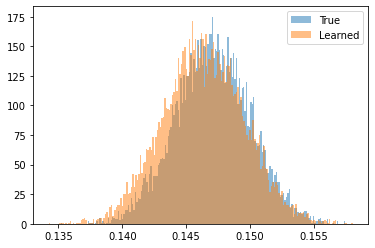

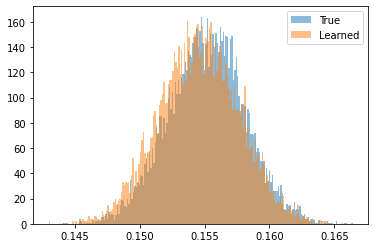

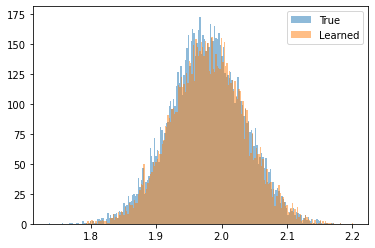

In [55]:
samples = model.sample(10000)
np_samples = np.array(samples.detach().cpu())
print(np.shape(np_samples))

sample_loader = DataLoader(dataset_train,
                          num_workers = 4,
                          batch_size = 10000, #256 is the default batch size
                          shuffle = True)

for batch_idx, (data, _) in enumerate(sample_loader):
    data = flatten_data(data)
    break

np_data = np.array(data)

for index in range(0, 3, 1):
    plt.hist(np_data[:, index], label = "True", bins = 200, alpha = 0.5)
    plt.hist(np_samples[:, index], label = "Learned", bins = 200, alpha = 0.5)
    plt.legend()
    plt.show()